# Imaging Supernova

In this notebook, we will image a supernova with a low redshift. To fetch data, we will use the CADC package of astroquery, which queries data provided by the [Canadian Astronomical Data Centre](http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca ). This tutorial will end-to-end from querying to displaying an image.

## Table of Contents
* [1. Introduction](#Introduction)
* [2. Setup](#Setup)
* [3. Querying](#Querying)
* [4. Fetching Data](#Fetching-Data)
* [5. Ploting Results](#Ploting-Results)

## Introduction
Info about
* CADC
* Tables and columns in the database
* Supernova


## Setup
This tutorial will go through some of the basic functionalities of the CADC astroquery package. The CADC module can be installed using the command:

```
pip install --pre astroquery
```

(The `--pre` tag installs the pre-release version which we need because the CADC package is not in the latest release.) Alternatively, you can clone and install from the source:

```
# If you have a github account:
git clone git@github.com:astropy/astroquery.git
# If you do not:
git clone https://github.com/astropy/astroquery.git
cd astroquery
python setup.py install
```
Note that these commands can also be done in a jupyter notebook by either declaring the code cell a bash cell by pasting `%%bash` at the top of the cell, or preceding each line with a `!`.
More information about astroquery can be found at the [astroquery github repository](https://github.com/astropy/astroquery).

Now, onto the tutorial. The first step is to import the CADC module from astroquery.

In [1]:
from astroquery.cadc import Cadc
cadc = Cadc()


## Querying

### Find suitable target
For this tutorial, we want to look at low redshift supernova in the D2 field. To find a suitable supernova, we can look at the [Scolnic et al. Supernova Catalog](https://archive.stsci.edu/prepds/ps1cosmo/scolnic_datatable.html) where `Target ID` contains `D2` and `ZCMB` is `< 0.3`.

This gives 2 results: [05D2ah](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=snls05D2ah&submit=SIMBAD+search) and [06D2fb](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=snls06D2fb&submit=SIMBAD+search). Let's choose `05D2ah` to image.

Now we can query CADC database for objects that contain the `05D2ah` object as a target. After querying, we can filter down the results such that we only get objects of type `image` with energy in the range of $3000 \unicode[serif]{xC5}$ to $10000 \unicode[serif]{xC5}$. 

### Query Method 1: `query_name` function
The simplest way to query data by target name is to use the `query_name` function. It takes a string and [returns all the results that contain the string in the `target name` field](https://github.com/astropy/astroquery/blob/master/astroquery/cadc/core.py#L205-L208). After querying, we can further filter down the results using boolean masks on the data. In order to filter the data, we need to see which columns are in the results, and also what data type they are. So lets first do the query and then print the resulting columns and their descriptions.



In [2]:
# Fetch the results that contain the object name as a target
object_name = '05D2ah'
#object_name = '06D2fb'
results = cadc.query_name(object_name)

# Normally we can just use results.info, but the formatting makes it hard to read
formatter = '{:34}| {:8}| {}'

print(formatter.format('Name', 'Unit', 'Description'))
print(90 * '*')
for col in results.columns.values():
    info = col.info
    print(formatter.format(info.name, str(info.unit), info.description))


Name                              | Unit    | Description
******************************************************************************************
caomObservationURI                | None    | unique URI for this observation
sequenceNumber                    | None    | sequence number assigned by the observatory
proposal_keywords                 | None    | proposal keywords (separated by |)
target_standard                   | None    | intended target is a standard (0=false, 1=true)
target_redshift                   | None    | redshift of intended target
target_moving                     | None    | flag for moving target
target_keywords                   | None    | target keywords (separated by |)
targetPosition_equinox            | None    | equinox of target position coordinate system
targetPosition_coordinates_cval1  | deg     | longitude of target position
targetPosition_coordinates_cval2  | deg     | latitude of target position
telescope_geoLocationX            | None    | 

Looking through the columns, we want results that have the `energy_bounds_lower` field greater than $3000 \unicode[serif]{xC5}$, `energy_bounds_upper` field less than $10000 \unicode[serif]{xC5}$ and `dataProductType` of type 'image'. Since the energy bounds fields are in unit $m$, we will make a function to convert angstroms to meters. Once we filter the results, we will display a subset of the columns (since there are so many!) using the astropy table `show_in_notebook` method.


In [3]:
# Construct the filter
ang_to_m = lambda ang: ang*1e-10

lower_bound_m = ang_to_m(3000)
upper_bound_m = ang_to_m(10000)
results_filter = (results['energy_bounds_lower']>= lower_bound_m) &\
                 (results['energy_bounds_upper']<= upper_bound_m) &\
                 (results['dataProductType'] == 'image')

# Apply the filter to the results
filtered_results = results[results_filter]

print('Number of results pre-filter: {}'.format(len(results)))
print('Number of results: {}'.format(len(filtered_results)))

columns_subset = ['productID', 'collection', 'observationID', 'energy_bandpassName', \
                  'calibrationLevel', 'position_dimension_naxis1', 
                  'position_dimension_naxis2', 'intent', 'target_name', 'telescope_name', \
                  'instrument_name', 'position_bounds', 'dataProductType']

filtered_results[columns_subset].show_in_notebook()


Number of results pre-filter: 6
Number of results: 4


idx,productID,collection,observationID,energy_bandpassName,calibrationLevel,position_dimension_naxis1,position_dimension_naxis2,intent,target_name,telescope_name,instrument_name,position_bounds,dataProductType
,,,,,,,,,,,,deg,
0,GN-2004B-Q-16-82-004,GEMINI,GN-2004B-Q-16-82-004,r,1,2080,4608,science,05D2ah,Gemini-North,GMOS-N,[150.3233722583425 1.8422707315077402 150.32331577433644 1.884432219938359 150.41667813377651 1.8846451600602616 150.41673238354682 1.842483668996208],image
1,GN-2004B-Q-16-82-002,GEMINI,GN-2004B-Q-16-82-002,r,1,2080,4608,science,05D2ah,Gemini-North,GMOS-N,[150.32338008674503 1.8422293367578795 150.3233228712942 1.8843909242644925 150.4166869298773 1.8846041366091688 150.41674191109584 1.8424425464303613],image
2,GN-2004B-Q-16-82-001,GEMINI,GN-2004B-Q-16-82-001,r,1,1056,2304,science,05D2ah,Gemini-North,GMOS-N,[150.3233815847936 1.8422289721864904 150.32332330929293 1.8850392218425782 150.41668783940196 1.8852524827476165 150.41674384628485 1.8424422303694865],image
3,GN-2004B-Q-16-82-003,GEMINI,GN-2004B-Q-16-82-003,r,1,2080,4608,science,05D2ah,Gemini-North,GMOS-N,[150.32337776170982 1.842182616781287 150.32332075994816 1.8843441626954263 150.4166841361924 1.8845574313207447 150.41673890379732 1.8423958827459035],image


### Query Method 2: ADQL
The second method is to bundle the query and filtering in one using Astronomical Data Query Language, or ADQL. In this case, we will do both the querying and the filtering in one step.

In [4]:
query_vars = { 'object_name': object_name, 'lower': lower_bound_m, 'upper': upper_bound_m}

query = '''SELECT *
FROM caom2.Plane AS Plane 
JOIN caom2.Observation AS Observation ON Plane.obsID = Observation.obsID 
WHERE ( ( Observation.target_name LIKE '%{object_name}%' )
AND ( Plane.energy_bounds_lower >= {lower} )
AND ( Plane.energy_bounds_upper <= {upper} ) 
AND ( Plane.dataProductType = 'image'))'''.format(**query_vars)

job = cadc.run_query(query, 'sync')
results = job.get_results()

results[columns_subset].show_in_notebook()

idx,productID,collection,observationID,energy_bandpassName,calibrationLevel,position_dimension_naxis1,position_dimension_naxis2,intent,target_name,telescope_name,instrument_name,position_bounds,dataProductType
,,,,,,,,,,,,deg,
0,GN-2004B-Q-16-82-004,GEMINI,GN-2004B-Q-16-82-004,r,1,2080,4608,science,05D2ah,Gemini-North,GMOS-N,[150.3233722583425 1.8422707315077402 150.32331577433644 1.884432219938359 150.41667813377651 1.8846451600602616 150.41673238354682 1.842483668996208],image
1,GN-2004B-Q-16-82-002,GEMINI,GN-2004B-Q-16-82-002,r,1,2080,4608,science,05D2ah,Gemini-North,GMOS-N,[150.32338008674503 1.8422293367578795 150.3233228712942 1.8843909242644925 150.4166869298773 1.8846041366091688 150.41674191109584 1.8424425464303613],image
2,GN-2004B-Q-16-82-001,GEMINI,GN-2004B-Q-16-82-001,r,1,1056,2304,science,05D2ah,Gemini-North,GMOS-N,[150.3233815847936 1.8422289721864904 150.32332330929293 1.8850392218425782 150.41668783940196 1.8852524827476165 150.41674384628485 1.8424422303694865],image
3,GN-2004B-Q-16-82-003,GEMINI,GN-2004B-Q-16-82-003,r,1,2080,4608,science,05D2ah,Gemini-North,GMOS-N,[150.32337776170982 1.842182616781287 150.32332075994816 1.8843441626954263 150.4166841361924 1.8845574313207447 150.41673890379732 1.8423958827459035],image


Notice how we have the same number of results using both the two methods? Pretty  neat :)

## Fetching Data
Now let's choose two images, find a suitable cutout, download them, and display them. We will use the `get_data_urls` function to actually access the data.

In [5]:
# Get links to the data
urls = cadc.get_data_urls(results)

print(urls)

['https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/GEMINI/N20050108S0186.fits.gz?RUNID=tv7rbo39ibkh7726', 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/GEMINI/N20050108S0184.fits.gz?RUNID=hsjl7aj113fn09do', 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/GEMINI/N20050108S0183.fits.gz?RUNID=zucavko3d68e33rs', 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/GEMINI/N20050108S0185.fits.gz?RUNID=uznp5h6x4ux2js7m']


The stucture of the url's can be broken into a few parts. Take `https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/GEMINI/N20050108S0186.fits.gz?RUNID=tv7rbo39ibkh7726` as an example...
- `https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/`: This is the service url. The 'data/pub' ending accesses all public files. For files the requires authorization, there will be a redirect to 'data/auth' which require authorization
- `GEMINI`: This is the archive name.
- `N20050108S0186.fits.gz`: This is the file name.
- `RUNID=tv7rbo39ibkh7726`: TODO: Get a good definition for this!! These are additional query parameters. I don't exactly know what this means!

The urls give access to the actual data, so now we can fetch the file, get data to calculate a cutout, open it with the astropy fits module, and display an image!


### Calculating cutouts

One thing to note is that the data products probably contain much more information than we actually need. In order to reduce the amount of data and total processing time, we can request cutouts of the fits files that only contain the slice of information that we want. In order to do a cutout, we need the range of pixels we want, and/or the fits extensions that we want. In this particular case, we want to compare the same area on multiple different files, so we want to do a cutout based on the coordinates we want to look at. In order to do this, we will grab the ICRA coordinates of the [05D2ah](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=snls05D2ah&submit=SIMBAD+search) object ( which are 10h01m28.728s +01d51m45.83s) and recruit the `cadccutout` package which can transform coordinates to the pixel range used to perform the cutout.


In [7]:
from cadccutout import Transform
from astropy.io import fits
from astropy.coordinates import SkyCoord

def cutout_pixels_from_position_with_ext(cutout_position, url, ext=0):
    transform = Transform()
    to_cutout_string = lambda pix_range: '[{}][{}:{},{}:{}]'.format(ext, pix_range[0][0], 
                                                                    pix_range[0][1], 
                                                                    pix_range[1][0], 
                                                                    pix_range[1][1])
    try:
        header = fits.getheader(url, ext)
        hdu_pixels = transform.world_to_pixels([cutout_position], header)
        return to_cutout_string(hdu_pixels.get_ranges())
    except TypeError:
        return (cutout_pixels_from_position_with_ext(cutout_position, url, ext=ext+1) if
                ext==0 else None)

def cutout_pixels_from_position(cutout_position, url, ext=0):
    transform = Transform()
    to_cutout_string = lambda pix_range: '[{}:{},{}:{}]'.format(pix_range[0][0], 
                                                                pix_range[0][1], 
                                                                pix_range[1][0], 
                                                                pix_range[1][1])
    try:
        header = fits.getheader(url, ext)
        hdu_pixels = transform.world_to_pixels([cutout_position], header)
        return to_cutout_string(hdu_pixels.get_ranges())
    except TypeError:
        return (cutout_pixels_from_position(cutout_position, url, ext=ext+1) if 
                ext==0 else None)
    
# TODO: Figure out how to extract coordinates?
c = SkyCoord('10h01m28.728s', '+01d51m45.83s', frame='icrs', unit='deg')
coordinates = { 'ra': c.ra.degree, 'dec': c.dec.degree, 'radius': 0.005}
cutout_region_string = 'CIRCLE {ra} {dec} {radius}'.format(**coordinates)

cutouts = [cutout_pixels_from_position_with_ext(cutout_region_string, url) for url in urls]

print(cutouts)


['[1][757:1251,2073:2567]', '[1][759:1253,2073:2567]', '[1][379:627,1036:1284]', '[1][761:1255,2073:2567]']


### Retriving Data with Requests
With the cutout values, we can now download the data. There are many different methods to perform a cutout, but today we will add the cutout string to the parameter in the request. More information about requesting CADC data can be found [in the documentation](http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/doc/data/).


In [13]:
import re
import requests
from astropy.wcs import WCS

#TODO: Make this read file if already there
#TODO: Catch 400 errors
def download_url_to_file(url, cutout=None, data_dir='data'):
    '''Takes a url, downloads the resource, saves it in the data directory with the name 
    specified in the response Content Disposition, and returns the file path and name'''

    def get_filename_from_response(response):
        content_disposition = response.headers['Content-Disposition']
        return re.findall("filename=(.+)", content_disposition)[0]

    resp = requests.get(url, params={'cutout': cutout}) if cutout else requests.get(url)
    fname = get_filename_from_response(resp)
    file_name_and_path = '{data_dir}/{fname}'.format(data_dir=data_dir, fname=fname)
    # Note: wb will overwrite if something is already there
    with open(file_name_and_path, 'wb') as f:
        f.write(resp.content)
        
    return file_name_and_path

def get_image_data(file, ext=0):
    '''Returns the image data and wcs coordinate data of a fits file at the 
    given extension'''
    with fits.open(file, ignore_missing_end=True) as hdulist:
        hdulist.info()
        w = WCS(hdulist[ext].header)
        image_data = hdulist[ext].data
    return image_data, w

def get_image_data_from_url(url, cutout=None, ext=0):
    '''Returns the image data and wcs coordinate data of a fits file at the 
    given extension'''
    data_url = url + '&cutout={}'.format(cutout) if cutout else url
    with fits.open(data_url, ignore_missing_end=True) as hdulist:
        hdulist.info()
        w = WCS(hdulist[ext].header)
        image_data = hdulist[ext].data
    return image_data, w

# To save to a file then read to image data
#fname_list = [download_url_to_file(url, cutout=cutout) for url, cutout 
#              in zip(urls, cutouts)]
#data_list = [get_image_data(fname) for fname in fname_list]

# To read from url
data_list = [get_image_data_from_url(url, cutout=cutout) for url, cutout 
             in zip(urls, cutouts)]


Filename: /home/badune/.astropy/cache/download/py3/7cacd2d0151f6c6cce20da8897fe95de
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY      -1 PrimaryHDU      39   (495, 495)   int16 (rescales to uint16)   


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


Filename: /home/badune/.astropy/cache/download/py3/cd742b56967f23414ab936300a3f266c
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY      -1 PrimaryHDU      39   (495, 495)   int16 (rescales to uint16)   


Filename: /home/badune/.astropy/cache/download/py3/4b92486a04c50a2dc963b968e4d98f03
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY      -1 PrimaryHDU      39   (249, 249)   int16 (rescales to uint16)   


Filename: /home/badune/.astropy/cache/download/py3/1ea081cb71a891d9e7a7e8c10baddc59
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY      -1 PrimaryHDU      39   (495, 495)   int16 (rescales to uint16)   


## Ploting Results

Now that we have the image data and the coordinate data of all our cutouts, we can begin to plot the data!

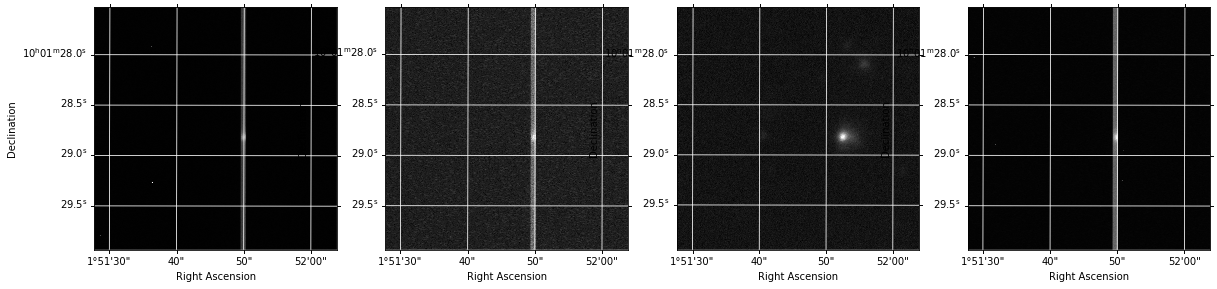

In [11]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.visualization import (LinearStretch, ImageNormalize, PercentileInterval, 
                                   MinMaxInterval)

#TODO: Add lables and titles!
#TODO: look and see how to make imshow better
def print_image_stats(image_data):
    stats = {'min': np.nanmin(image_data), 'max': np.nanmax(image_data), 
             'mean': np.nanmean(image_data), 'std': np.nanstd(image_data)}
    print('Min: {min} \nMax: {max} \nMean: {mean}\nStdev: {std}'.format(**stats))
    
def plot_image_list(data_list, geo=None):

    if geo is None:
        geo = (1, len(data_list)) #nrows, ncols
        
    fig = plt.figure(figsize=(20,10))
    for idx, (image_data, wcs) in enumerate(data_list):
        ax = plt.subplot(geo[0], geo[1], idx+1, projection=wcs)
        image_data_norm = ImageNormalize(image_data, interval=MinMaxInterval(), 
                                         stretch=LinearStretch())
        ax.imshow(image_data, norm=image_data_norm, cmap='gray')
        ax.coords.grid(color='white', ls='solid')
        ra, dec = ax.coords['ra'], ax.coords['dec']
        ra.set_ticklabel_position('lb')
        dec.set_ticklabel_position('lb')
        ra.set_axislabel('Right Ascension')
        dec.set_axislabel('Declination')


plot_image_list(data_list)

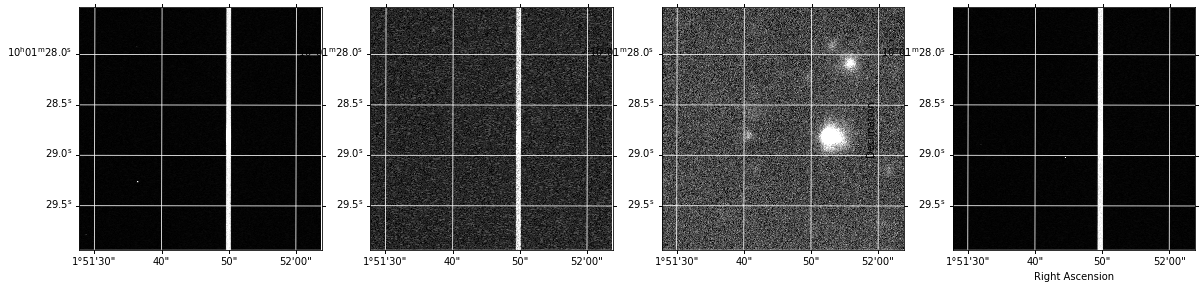

In [12]:
def plot_image_list_same_axes(data_list, geo=None):
    if geo is None:
        geo = (1, len(data_list)) #nrows, ncols
        
    wcs_trans = data_list[1][1]   
    
    fig, ax_list = plt.subplots(geo[0], geo[1], figsize=(20,10), sharex=True, sharey=True, 
                                subplot_kw=dict(projection=wcs_trans))
    flat_ax_list = list(np.array(ax_list).flat)

    
    for ax, (image_data, wcs) in zip(flat_ax_list, data_list):
        image_data_norm = ImageNormalize(image_data, interval=PercentileInterval(99), 
                                         stretch=LinearStretch())
        ax.imshow(image_data, transform=ax.get_transform(wcs), norm=image_data_norm, 
                  cmap='gray')
        ax.coords.grid(color='white', ls='solid')
        ra, dec = ax.coords['ra'], ax.coords['dec']
        ra.set_ticklabel_position('lb')
        dec.set_ticklabel_position('lb')
        
    plt.xlabel('Right Ascension')
    plt.ylabel('Declination')

plot_image_list_same_axes(data_list)